## In this notebook we will evluate our model
We will make use of various SKLearn-supported metrics, such as the F1 and ROC/AUC scores.

In [1]:
import pandas as pd
import numpy as np
from joblib import load 
from sklearn import metrics
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

with open("C:/Users/lbianculli/dev/us_equities/models/sk_random_forest_final.f", "rb") as f:
    model = load(f)
    
with open("C:/Users/lbianculli/dev/us_equities/models/sk_random_forest_final.f", "wb") as f:
    pickle.dump(model, f)
    
with open("C:/Users/lbianculli/dev/us_equities/models/train_data.p", "rb") as f:
    train_data, test_data, holdout_data, train_labels, test_labels, holdout_labels = pickle.load(f)
    
current_data = pd.read_csv("current_tickers.csv").drop(["Unnamed: 0"], axis=1)

Create a summary function that returns an evaluation of our model and returns the optimal probability threshold for calculating the ROC/AUC score.

In [2]:
def summary(fit_clf, test_data, test_labels):
    """ 
    Compile classification summary for a trained classifier
    fit_clf: trained SKLearn classifier
    test_data: test data with same number of features as data used to train the fit_clf
    test_labels: labels corresponding to test_data
    
    returns: 
    best ROC threshold according to Youden’s J statistic and probabilities according to 50/50 threshold
    """
    plt.rcParams['figure.figsize'] = (8.0, 5.0)

    # use model to calculate probs and get baseline probs
    probs = fit_clf.predict_proba(test_data)
    ns_probs = [0 for _ in range(len(test_labels))]

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]

    # calculate scores
    ns_auc = metrics.roc_auc_score(test_labels, ns_probs)
    clf_auc = metrics.roc_auc_score(test_labels, probs)

    # plot the roc curve for the model
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, probs)
    ns_fpr, ns_tpr, _ = metrics.roc_curve(test_labels, ns_probs)
    
    # threshold tuning
    j = tpr - fpr
    idx = np.argmax(j)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Classifier', alpha=.25)
    plt.scatter(fpr[idx], tpr[idx], marker="o", color="black", label="best")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # summary stats
    print(f"No Skill ROC AUC = {ns_auc:.2f}")
    print(f"Classifier ROC AUC = {clf_auc:.2f}")
    print(f"Best Threshold: {thresholds[idx]:.2f}\n")

    preds = fit_clf.predict(test_data)
    acc = metrics.accuracy_score(test_labels, preds)
    print(f"Classifier Accuracy: {acc*100:.1f}%")

    f1 = metrics.f1_score(test_labels, preds)
    print(f"Classifier F1: {f1*100:.1f}%\n")

    # confusion matrix
    print(classification_report(test_labels, preds))
    
    return thresholds[idx], probs

def evaluate_threshold(test_probs, test_labels, threshold=.5):
    """ 
    Evaluate various classification scores of a classifier at a given ROC threshold
    test_probs: probabilities assigned by classifer to test data labels
    test_labels: labels corresponding to test_probs
    threshold: threshold according to which the predicted probabilities will be judged and new evaluation produced.
    
    returns: 
    New predictions according to chosen threshold
    """
    thresholded_preds = np.where(test_probs >= threshold, 1, -1).astype(np.int64)
    f1 = metrics.f1_score(test_labels, thresholded_preds)
    acc = metrics.accuracy_score(test_labels, thresholded_preds)
    print(classification_report(test_labels, thresholded_preds))
    
    return thresholded_preds

## Classifier Metrics
The primary metrics we are going to explore are accuracy, ROC/AUC score, and F1 score

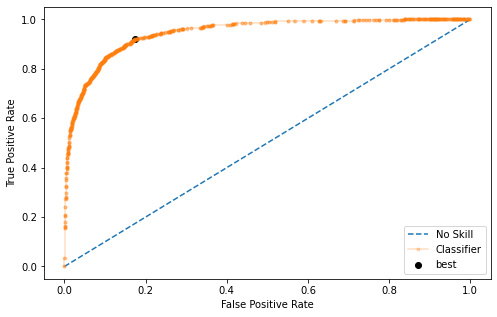

No Skill ROC AUC = 0.50
Classifier ROC AUC = 0.95
Best Threshold: 0.24

Classifier Accuracy: 89.8%
Classifier F1: 71.2%

              precision    recall  f1-score   support

          -1       0.90      0.98      0.94      4079
           1       0.87      0.60      0.71      1077

    accuracy                           0.90      5156
   macro avg       0.89      0.79      0.83      5156
weighted avg       0.90      0.90      0.89      5156



In [3]:
best_threshold, test_probs = summary(model, test_data, test_labels)

Normally, we would use the threshold prboability returned by this function to define new labels. However, we are primarily concerned with the precision of our model (how many of our positive predictions are correct); we want to limit false negatives. More specifically, for those we predict positive, how many do we correctly predict? We could improve precision by adjusting the threshold up (e.g. from .5 to .55). This would likely negatively affect evaluation metrics. Let's take a look.

In [11]:
new_preds = evaluate_threshold(test_probs, test_labels, threshold=.55)

              precision    recall  f1-score   support

          -1       0.89      0.99      0.94      4079
           1       0.91      0.55      0.68      1077

    accuracy                           0.89      5156
   macro avg       0.90      0.77      0.81      5156
weighted avg       0.90      0.89      0.88      5156



### Testing holdout data
Finally, after we are comfortable with the test scores and follow-up metrics, we can use our holdout data, which should not have been touched up to this point. If this score looks good, we can be confident in our model

In [12]:
holdout_preds = model.predict(holdout_data)
holdout_acc = metrics.accuracy_score(holdout_preds, holdout_labels)
print(f"Holdout Accuracy: {holdout_acc*100:.1f}%")

Holdout Accuracy: 90.0%


## Evaluate Quarter Returns
Now that we have done the premodeling and postmodeling steps, let's evaluate how the securities that our model chose would have performed

In [13]:
import yfinance as yf

current_data = current_data.sort_values("market_cap", ascending=False)

# get largest and smallest companies to achieve some cap exposure
current_tickers = list(current_data.tail(10)["ticker"]) + list(current_data.head(10)["ticker"])

# get returns for each ticker
#TODO: make date dynamic
rets = {}
for ticker in current_tickers: 
    ticker_obj = yf.Ticker(ticker)
    ticker_data = ticker_obj.history(start='2021-01-01', end='2021-04-01')
    ticker_data["rets"] = ticker_data["Close"].pct_change()
    ticker_data = ticker_data.dropna()
    cum_rets = (ticker_data["rets"] + 1).cumprod() - 1

    rets[ticker] = cum_rets
    
mean_rets = np.array(list(rets.values()))


# get cumulative return of SPY for comparison
ticker_obj = yf.Ticker("SPY")
spy_data = ticker_obj.history(start='2021-01-1', end='2021-04-1')
spy_data["rets"] = spy_data["Close"].pct_change()
spy_data = spy_data.dropna()

spy_mean_ret = spy_data["rets"].mean()

In [14]:
spy_cum_rets = (spy_data["rets"] + 1).cumprod() - 1
spy_cum_rets[-1]

print(f"SPY returned {spy_cum_rets[-1]*100:.2f}%")
print(f"Theoretical Portfolio returned {np.mean(mean_rets)*100:.2f}%")

SPY returned 7.82%
Theoretical Portfolio returned 12.00%


It looks like our model performed well. However, this does not guarentee future returns. To be more confident in our model, we should primarily look at two things: backtests and statistical analysis.

In the next part of this extended analysis, we will look at the latter.